# Imports

In [1050]:
!pip install --upgrade --no-cache-dir gdown --quiet


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1051]:
import re
import gdown
import json
import os
import logging
import pickle
from pathlib import Path

import numpy as np

from tensorflow.keras.utils import pad_sequences
from keras.models import Model
from keras.layers import Embedding, Input, LSTM, Dense
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical

import matplotlib.pyplot as plt
import seaborn as sns


# Downloading dataset

In [1052]:
if os.access('data_volunteers.json', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download'
    output = 'data_volunteers.json'
    gdown.download(url, output, quiet=False)
else:
    print("Dataset was already downloaded.")

Dataset was already downloaded.


# Constants

In [1053]:
MAX_VOCAB_SIZE = 8000
MAX_LENGTH = 20
N_UNITS = 128
EPOCHS = 30
LSTM_DROPOUT = 0.2

# Preprocessing dataset

In [1054]:
text_file = "data_volunteers.json"
with open(text_file) as f:
    data = json.load(f)

In [1055]:
data[0].keys()

dict_keys(['dialog', 'start_time', 'end_time', 'bot_profile', 'user_profile', 'eval_score', 'profile_match', 'participant1_id', 'participant2_id'])

In [1056]:
chat_in = []
chat_out = []

input_sentences = []
output_sentences = []
output_sentences_inputs = []


def clean_text(txt):
    txt = txt.lower()
    txt.replace("\'d", " had")
    txt.replace("\'s", " is")
    txt.replace("\'m", " am")
    txt.replace("don't", "do not")
    txt = re.sub(r'\W+', ' ', txt)

    return txt


for line in data:
    for i in range(len(line['dialog']) - 1):
        # chat_in = questions
        # chat_out = answers
        chat_in = clean_text(line['dialog'][i]['text'])
        chat_out = clean_text(line['dialog'][i + 1]['text'])

        if len(chat_in) >= MAX_LENGTH or len(chat_out) >= MAX_LENGTH:
            continue

        input_sentence, output = chat_in, chat_out

        output_sentence = output + ' <eos>'
        output_sentence_input = '<sos> ' + output

        input_sentences.append(input_sentence)
        output_sentences.append(output_sentence)
        output_sentences_inputs.append(output_sentence_input)


print("Total rows:", len(input_sentences))

Total rows: 1903


In [1057]:
input_sentences[1], output_sentences[1], output_sentences_inputs[1]

('hi how are you ', 'not bad and you  <eos>', '<sos> not bad and you ')

# Getting word2idx_inputs and max_input_len

In [1058]:
input_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)

word2idx_inputs = input_tokenizer.word_index
print("Total tokens in input vocab:", len(word2idx_inputs))

max_input_len = max(len(sen) for sen in input_integer_seq)
print("Longest input sentence:", max_input_len)

Total tokens in input vocab: 752
Longest input sentence: 7


# Getting word2idx_outputs, max_out_len and num_words_output

In [1059]:
output_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='!"#$%&()*+,-./:;=¿?@[\\]^_`{|}~\t\n')
output_tokenizer.fit_on_texts(["<sos>", "<eos>"] + output_sentences)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

word2idx_outputs = output_tokenizer.word_index
print("Total tokens in output vocab:", len(word2idx_outputs))

num_words_output = min(len(word2idx_outputs) + 1, MAX_VOCAB_SIZE)
print("Total tokens in output:", num_words_output)

max_out_len = max(len(sen) for sen in output_integer_seq)
print("Longest output sentence:", max_out_len)

Total tokens in output vocab: 714
Total tokens in output: 715
Longest output sentence: 7


# Getting encoder_input_sequences, decoder_output_sequences and decoder_targets

In [1060]:
encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences shape:", encoder_input_sequences.shape)

decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_input_sequences shape:", decoder_input_sequences.shape)

decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_output_sequences shape:", decoder_output_sequences.shape)

decoder_targets = to_categorical(decoder_output_sequences, num_classes=num_words_output)
print("decoder_targets shape:", decoder_targets.shape)

encoder_input_sequences shape: (1903, 7)
decoder_input_sequences shape: (1903, 7)
decoder_output_sequences shape: (1903, 7)
decoder_targets shape: (1903, 7, 715)


# Donwloading fasttext embeddings

In [1061]:
if os.access('fasttext.pkl', os.F_OK) is False:
    url = 'https://drive.google.com/u/0/uc?id=1Qi1r-u5lsEsNqRSxLrpNOqQ3B_ufltCa&export=download&confirm=t'
    output = 'fasttext.pkl'
    gdown.download(url, output, quiet=False)
else:
    print("Dataset already downloaded")

Dataset already downloaded


In [1062]:
class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicts para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2 ** 28 - 1  # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2 ** 28 - 1  # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx + max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

In [1063]:
model_embeddings = FasttextEmbeddings()

In [1064]:
print('preparing embedding matrix...')
embed_dim = model_embeddings.N_FEATURES
words_not_found = []

nb_words = min(MAX_VOCAB_SIZE, len(word2idx_inputs) + 1)
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word2idx_inputs.items():
    if i >= nb_words:
        continue
    embedding_vector = model_embeddings.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        embedding_matrix[i] = embedding_vector
    else:
        # words not found in embedding index will be all-zeros.
        words_not_found.append(word)

print('number of null word embeddings:', np.sum(np.sum(embedding_matrix ** 2, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 1


In [1065]:
embedding_matrix.shape

(753, 300)

# Training model

In [1066]:
# define training encoder
encoder_inputs = Input(shape=(max_input_len))

encoder_embedding_layer = Embedding(
    input_dim=nb_words,
    output_dim=embed_dim,
    input_length=max_input_len,
    weights=[embedding_matrix],
    trainable=False)

encoder_inputs_x = encoder_embedding_layer(encoder_inputs)

encoder = LSTM(N_UNITS,
               return_state=True,
               dropout=LSTM_DROPOUT,
               )

encoder_outputs, state_h, state_c = encoder(encoder_inputs_x)
encoder_states = [state_h, state_c]

# define training decoder
decoder_inputs = Input(shape=(max_out_len))
decoder_embedding_layer = Embedding(
    input_dim=num_words_output,
    output_dim=N_UNITS,
    input_length=max_out_len)
decoder_inputs_x = decoder_embedding_layer(decoder_inputs)

decoder_lstm = LSTM(N_UNITS,
                    return_sequences=True,
                    return_state=True,
                    dropout=LSTM_DROPOUT,
                    )
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

# Dense
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(loss='categorical_crossentropy', optimizer="Adam", metrics=['accuracy'])
model.summary()

Model: "model_106"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_180 (InputLayer)      [(None, 7)]                  0         []                            
                                                                                                  
 input_181 (InputLayer)      [(None, 7)]                  0         []                            
                                                                                                  
 embedding_74 (Embedding)    (None, 7, 300)               225900    ['input_180[0][0]']           
                                                                                                  
 embedding_75 (Embedding)    (None, 7, 128)               91520     ['input_181[0][0]']           
                                                                                          

## Encoder model

In [1067]:
encoder_model = Model(encoder_inputs, encoder_states)

## Decoder model

In [1068]:
decoder_state_input_h = Input(shape=(N_UNITS,))
decoder_state_input_c = Input(shape=(N_UNITS,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding_layer(decoder_inputs_single)

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs_single] + decoder_states_inputs, [decoder_outputs] + decoder_states)

In [1069]:
hist = model.fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_targets,
    epochs=EPOCHS,
    validation_split=0.2,
    )

Epoch 1/30
48/48 [==============================] - 5s 28ms/step - loss: 3.8398 - accuracy: 0.4530 - val_loss: 2.8436 - val_accuracy: 0.4653
Epoch 2/30
48/48 [==============================] - 1s 13ms/step - loss: 2.4295 - accuracy: 0.5083 - val_loss: 2.4956 - val_accuracy: 0.5718
Epoch 3/30
48/48 [==============================] - 1s 13ms/step - loss: 2.1357 - accuracy: 0.6235 - val_loss: 2.3461 - val_accuracy: 0.6280
Epoch 4/30
48/48 [==============================] - 1s 13ms/step - loss: 1.9957 - accuracy: 0.6387 - val_loss: 2.2784 - val_accuracy: 0.6307
Epoch 5/30
48/48 [==============================] - 1s 13ms/step - loss: 1.8891 - accuracy: 0.6500 - val_loss: 2.2211 - val_accuracy: 0.6400
Epoch 6/30
48/48 [==============================] - 1s 13ms/step - loss: 1.7779 - accuracy: 0.6764 - val_loss: 2.1722 - val_accuracy: 0.6599
Epoch 7/30
48/48 [==============================] - 1s 13ms/step - loss: 1.6683 - accuracy: 0.7092 - val_loss: 2.1179 - val_accuracy: 0.6663
Epoch 8/30
48

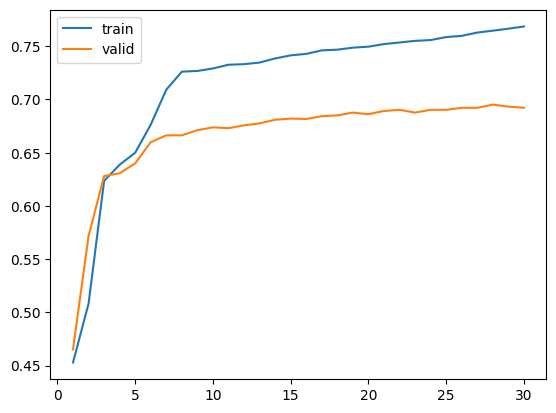

In [1070]:
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

# Inference

In [1071]:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [1072]:
def answer_question(input_seq):
    states_value = encoder_model.predict(input_seq)

    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']

    eos = word2idx_outputs['<eos>']

    output_sentence = []
    for _ in range(max_out_len):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        idx = np.argmax(output_tokens[0, 0, :])

        if eos == idx:
            break

        word = ''
        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        states_value = [h, c]
        target_seq[0, 0] = idx

    return ' '.join(output_sentence)

In [1073]:
def test_bot(input_test):
    integer_seq_test = input_tokenizer.texts_to_sequences([input_test])
    encoder_sequence_test = pad_sequences(integer_seq_test, maxlen=max_input_len)

    answer = answer_question(encoder_sequence_test)
    print('Input (question):', input_test)
    print('Response:', answer)

In [1074]:
test_bot('Do you read?')

1/1 [==============================] - 0s 14ms/step
Input (question): Do you read?
Response: i am in the city


In [1075]:
test_bot('Do you have any pet?')

1/1 [==============================] - 0s 14ms/step
Input (question): Do you have any pet?
Response: i am a student


In [1076]:
test_bot('Where are you from?')

1/1 [==============================] - 0s 14ms/step
Input (question): Where are you from?
Response: i am in the city


In [1077]:
test_bot('How are you?')

1/1 [==============================] - 0s 15ms/step
Input (question): How are you?
Response: i m fine


# Conclusion

Responses don't make sense in most cases, but are sentences well structured.